In [729]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

import shap

import joblib

In [666]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 50)

import warnings
warnings.filterwarnings('ignore')

## Import data

In [624]:
fs = pd.read_csv('fs_pax.csv')
fs.head()

,Unnamed: 0,DT_sched,Flight No,iata_code,International Domestic,Flight Distance,Flight Duration,Operating Airline Name,airline_icao,airline_type,Departure Concourse,date,Time,year,DOW_l,holiday,total_doses,BTS Aircraft Type Desc_1,ICAO Aircraft Code,IATA Aircraft Code,Seats,LF_adj,PAX_adj,PAX_bus,PAX_lei,airline_type_dum,region,Region_Africa,Region_Asia,Region_Canada,Region_Europe,Region_Latin America & Caribbean,Region_USA-Midwest,Region_USA-Northeast,Region_USA-Pacific West,Region_USA-Plains,Region_USA-Southeast,domintl_dum_0,domintl_dum_1,Time Category_Afternoon,Time Category_Evening,Time Category_Morning,Time Category_Overnight,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,ADG_II,ADG_III,ADG_IV,ADG_V,ADG_VI,Month,airline_iata_AI,airline_iata_AV,airline_iata_B0,airline_iata_B6,airline_iata_BA,airline_iata_BF,airline_iata_DL,airline_iata_EI,airline_iata_EK,airline_iata_ET,airline_iata_F9,airline_iata_FI,airline_iata_G4,airline_iata_LH,airline_iata_LO,airline_iata_LX,airline_iata_LY,airline_iata_NK,airline_iata_OS,airline_iata_PD,airline_iata_SK,airline_iata_SY,airline_iata_TP,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Hour_0,Hour_1,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,0,2021-01-02 11:15:00,106,DEL,International,7323,820,Air India,AIC,TR,B3,2021-01-02,11:15,2021,Saturday,1,4745800,BOEING 777-200/200LR,B772,77L,238,0.531511,168.330972,57.863772,110.467201,0,Asia,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2021-01-01 19:30:00,101,ORY,International,3648,440,La Compagnie,DJT,TR,B2,2021-01-01,19:30,2021,Friday,1,4438527,AIRBUS INDUSTRIE A321,A321,321,76,0.000000,0.000000,0.000000,0.000000,0,Europe,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2,2021-01-02 19:30:00,101,ORY,International,3648,440,La Compagnie,DJT,TR,B2,2021-01-02,19:30,2021,Saturday,1,4745800,AIRBUS INDUSTRIE A321,A321,321,76,0.000000,0.000000,0.000000,0.000000,0,Europe,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,3,2021-01-01 21:50:00,103,ORY,International,3648,430,La Compagnie,DJT,TR,B3,2021-01-01,21:50,2021,Friday,1,4438527,AIRBUS INDUSTRIE A321,A321,321,76,0.447152,51.042195,17.545754,33.496440,0,Europe,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,4,2021-01-02 21:50:00,103,ORY,International,3648,430,La Compagnie,DJT,TR,B3,2021-01-02,21:50,2021,Saturday,1,4745800,AIRBUS INDUSTRIE A321,A321,321,76,0.489067,55.826857,19.190482,36.636375,0,Europe,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [625]:
fs['DT_sched'] = pd.to_datetime(fs['DT_sched'])
fs = fs.set_index('DT_sched')

In [626]:
fs = fs.sort_index()

## Train-test split

How to split the data is a fundamental question of whether the flight schedule should be treated as time-series data or not. It certainly has a time component, but it isn't equal intervals like time-series data. But what is most important is that the flight schedule data has temporal autocorrelation. In other words, knowing about some flights on December 22, 2021 tells you something important about other flights on December 22, 2021. So randomly splitting the data isn't appropriate given that we will eventually be predicting the future, not the past.

This is also important when it comes to cross-validation and model tuning. See further discussion on this under the modeling section.

In [627]:
predictors = fs[['airline_type_dum',
       'Region_Africa', 'Region_Asia', 'Region_Canada', 'Region_Europe',
       'Region_Latin America & Caribbean', 'Region_USA-Midwest',
       'Region_USA-Northeast', 'Region_USA-Pacific West', 'Region_USA-Plains',
       'Region_USA-Southeast', 'Time Category_Afternoon',
       'Time Category_Evening', 'Time Category_Morning',
       'Time Category_Overnight', 'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4',
       'DOW_5', 'DOW_6','month_1', 'month_2', 'month_3', 'month_4', 'month_5', 
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 
       'Flight Distance', 'holiday','total_doses']]
targets = fs[['PAX_adj', 'PAX_bus', 'PAX_lei']]

In [628]:
#random train-test split. This is for reference, but I will ultimately tune models using date-separated train/test data
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(predictors,targets,test_size=.2)

In [629]:
print(X_train_r.shape, X_test_r.shape, y_train_r.shape, y_test_r.shape)

(15864, 37) (3966, 37) (15864, 3) (3966, 3)


In [630]:
#split data by month instead of random train-test split
test_mn = 'month_12'
X_test_mn = predictors[predictors[test_mn] == 1]
y_test_mn = targets[predictors[test_mn] == 1]
X_train_mn = predictors[predictors[test_mn] == 0]
y_train_mn = targets[predictors[test_mn] == 0]

In [631]:
print(X_train_mn.shape, X_test_mn.shape, y_train_mn.shape, y_test_mn.shape)

(17276, 37) (2554, 37) (17276, 3) (2554, 3)


In [632]:
#split data by date instead of random train-test split
split_date = pd.to_datetime('2021-12-02')
X_test = predictors.loc[predictors.index > split_date,:]
y_test = targets.loc[targets.index > split_date,:]
X_train = predictors.loc[predictors.index <= split_date,:]
y_train = targets.loc[targets.index <= split_date,:]

In [633]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17349, 37) (2481, 37) (17349, 3) (2481, 3)


## Preprocessing- scaling, pca

In [634]:
SS_X = StandardScaler()
SS_X.fit(X_train[['Flight Distance','total_doses']])
X_train[['distance_sc','total_doses_sc']] = SS_X.transform(X_train[['Flight Distance','total_doses']])
X_test[['distance_sc','total_doses_sc']] = SS_X.transform(X_test[['Flight Distance','total_doses']])

In [635]:
# drop unscaled predictor columns
X_train.drop(['Flight Distance','total_doses'],axis=1, inplace = True)
X_test.drop(['Flight Distance','total_doses'],axis=1, inplace = True)

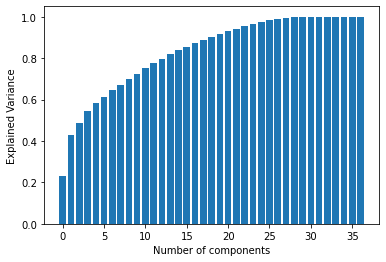

In [636]:
#explore the number of PCs to use
pca = PCA(X_train.shape[1])
X_train_p=pca.fit_transform(X_train)
eigenvalues = pca.explained_variance_ratio_
#plot explained variance over the number of compinents
n=X_train.shape[1]
plt.bar(np.arange(n), eigenvalues[:n].cumsum())
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")
plt.show()

In [637]:
# 14 principle components get >80% of the variation
eigenvalues[:n].cumsum()

array([0.22850129, 0.42713206, 0.48806248, 0.54286728, 0.58165356,
       0.61409907, 0.6438731 , 0.67189191, 0.69918374, 0.7251036 ,
       0.75030665, 0.77432601, 0.79744132, 0.81793767, 0.83773274,
       0.85524239, 0.87153552, 0.8876067 , 0.90310089, 0.91746488,
       0.93105338, 0.94288657, 0.95374874, 0.96438166, 0.97433837,
       0.98283125, 0.98943526, 0.99471351, 0.99684808, 0.99869948,
       0.99963539, 0.9998941 , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

In [638]:
# Fit the 14 PCs with training data, transform the test data too
pca = PCA(14)
pca.fit(X_train)
X_train_p = pca.transform(X_train)
X_test_p = pca.transform(X_test)

## Model evaluation functions

In [639]:
results = pd.DataFrame(columns=['Model','Hyperparameters','In-Sample R2', 'Out-of-Sample R2', 'Comments'])

In [640]:
def model_eval(fitted_model, multioutput):
    
    global X_train, X_test, y_train, y_test
    global param_grid

    if multioutput:
        y_tr = y_train
        y_te = y_test
    else:
        y_tr = y_train['PAX_adj']
        y_te = y_test['PAX_adj']

    print(fitted_model.best_params_)
    print(f'Cross validation score: {fitted_model.best_score_}')

    print(f'In sample r2: {r2_score(y_tr, fitted_model.predict(X_train))}')
    print(f'Out of sample r2: {r2_score(y_te, fitted_model.predict(X_test))}')

    i =0
    fig, axs = plt.subplots(nrows=len(param_grid), ncols=1, figsize=(5,15))
    for p, v in param_grid.items():
        pa = f'param_{p}'
        x = fitted_model.cv_results_[pa]
        y = fitted_model.cv_results_['mean_test_score']
        axs[i].scatter(x,y)
        axs[i].set_xlabel(p)
        i+=1

    plt.show()

In [641]:
def add_result(model, model_name, multioutput, comments):
    
    global results, X_train, X_test, y_train, y_test
    
    if multioutput:
        y_tr = y_train
        y_te = y_test
    else:
        y_tr = y_train['PAX_adj']
        y_te = y_test['PAX_adj']

    m = model_name
    hp = str(model.best_params_)
    isr2 = r2_score(y_tr, model.predict(X_train))
    osr2 = r2_score(y_te,model.predict(X_test))
    d = {'Model':m,'Hyperparameters':hp,'In-Sample R2':isr2,'Out-of-Sample R2':osr2,"Comments":comments}
    results = results.append(d,ignore_index=True)
    
    return results

In [642]:
def plot_result(model,vars,start_date,end_date):
    global X_train, X_test, y_train, y_test

    pred = model.predict(X_test)

    test_df = y_test.copy()
    test_df[['PAX_adj_pred','PAX_bus_pred','PAX_lei_pred']] = pred
    
    var_pred = [v+'_pred' for v in vars]
    var_all = vars + var_pred
    s_date = pd.to_datetime(start_date)
    e_date = pd.to_datetime(end_date)

    test_df.loc[(test_df.index >= s_date) & (test_df.index <= e_date),var_all].plot()

In [643]:
def plot_agg_result(model,vars,frequency,start_date,end_date):
    global X_train, X_test, y_train, y_test

    pred = model.predict(X_test)

    test_df = y_test.copy()
    test_df[['PAX_adj_pred','PAX_bus_pred','PAX_lei_pred']] = pred
    test_df[['PAX_adj_err','PAX_bus_err','PAX_lei_err']] = (test_df[['PAX_adj','PAX_bus','PAX_lei']] - pred)*-1
    
    test_df = test_df.reset_index()
    test_df = test_df.groupby(pd.Grouper(key="DT_sched", freq=frequency)).sum()

    var_pred = [v+'_pred' for v in vars]
    var_all = vars + var_pred
    var_err = [v+'_err' for v in vars]
    s_date = pd.to_datetime(start_date)
    e_date = pd.to_datetime(end_date)

    test_df.loc[(test_df.index >= s_date) & (test_df.index <= e_date),var_all].plot()
    test_df.loc[(test_df.index >= s_date) & (test_df.index <= e_date),var_err].plot()


In [644]:
shap.initjs()

In [645]:
def forceplt(model,index_num):
    summary = shap.kmeans(X_train,100)
    explainer = shap.KernelExplainer(model = model.predict, data = summary)
    shap_values_1 = explainer.shap_values(X_test.iloc[index_num,:])
    return shap.force_plot(explainer.expected_value[0],shap_values_1[0],X_test.iloc[index_num,:])

In [96]:
forceplt(clf_rf,35)

In [14]:
# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test)

## Model by model

Given that the flight schedule is time-series-esque, using the default kfolds cross-validation for tuning models presents a problem. The fundamental problem is the same as discussed in the train-test split section: because the flights are not independent of one another (i.e. they have temporal autocorrelation), randomly selecting data for each fold means that the model is learning relevant information about the held-out validation data just based on its temporal proximity to other flights scheduled on the same day, week, month. Effectively, the training data is leaking into the validation data, which makes it easier for the model to "predict" on the validation data. This results in inflated validation scores and makes the models susceptible to overfitting, even when using cross-validation. Gridsearchcv with kfolds recommends more complex model parameters, e.g. higher max_depths on random forests, which results in overfitting and poorer performance on the totally isolated test data. The solution to this is to use walk-forward validation instead of kfold.

I confirmed this by testing gridsearchcv with both cv methods. I'm not including the code here, but here is a summary of the results. Kfolds had much higher cross-validation averages than walk-forward -- this is because walk-forward starts the first validation with little data, so do not be alarmed by the very low CV scores during tuning! When I let the gridsearchcv choose the best parameters, kfolds gravitates towards higher max_depth, whereas walk-forward prefers shallower max_depth. Overall in-sample performance is therefore better with kfolds, but this is almost certainly overfitted. The true measure is the out-of-sample r2, and those are very similar between kfolds and WF. This suggests that k-folds is overfitting in-sample and that I should use walk-forward validation!

(Note also that kfolds cross-validation does not shuffle/randomize the training data by default! This caused me hours of confusion and frustration when comparing the cv methods! See https://scikit-learn.org/stable/modules/cross_validation.html#a-note-on-shuffling)

In [ ]:
#This is a time-series splitter for cross-validating, instead of using gridsearchcv's default kfolds.
tscv = TimeSeriesSplit(n_splits = 5)

### OLS

In [732]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [733]:
print(r2_score(y_train, lr.predict(X_train)))
print(r2_score(y_test, lr.predict(X_test)))

0.50069494503685
0.5434462102700306


In [745]:
# manually add to the results table
d = {'Model':'ols','Hyperparameters':'','In-Sample R2':r2_score(y_train, lr.predict(X_train)),'Out-of-Sample R2':r2_score(y_test, lr.predict(X_test)),"Comments":''}
results = results.append(d,ignore_index=True)
results

,Model,Hyperparameters,In-Sample R2,Out-of-Sample R2,Comments
0,adaboost,"{'base_estimator__max_depth': 8, 'learning_rate': 0.01, 'n_estimators': 100}",0.715079,0.594117,"wf validation, first fit"
1,Random Forest,"{'max_depth': 10, 'n_estimators': 100}",0.811008,0.698365,wf validation
2,adaboost,"{'base_estimator__max_depth': 10, 'learning_rate': 0.001, 'n_estimators': 100}",0.78032,0.657991,"wf validation, second fit"
3,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.03, 'n_estimators': 150}",0.796073,0.653159,third fit
4,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.01, 'n_estimators': 250}",0.774773,0.642767,fourth fit
5,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.005, 'n_estimators': 150}",0.755069,0.629464,fifth fit
6,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.005, 'n_estimators': 300}",0.76231,0.626387,sixth fit - checking lots of stumps
7,gradient boost,"{'learning_rate': 0.06, 'max_depth': 5, 'n_estimators': 100}",0.781381,0.636614,first fit
8,gradient boost,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}",0.771185,0.629884,second fit
9,gradient boost,"{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000}",0.824779,0.668993,"third fit, more trees"


### Ridge

{'alpha': 22.229964825261934}
0.22235569459665502


<AxesSubplot:>

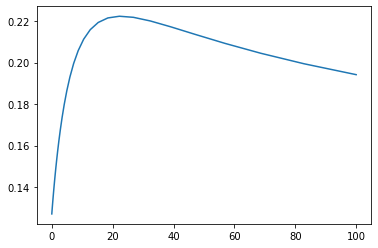

In [739]:
alpha = np.logspace(-2,2,50)
param_grid = {'alpha': alpha}
rr = Ridge()
clf_rr = GridSearchCV(rr, param_grid=param_grid, cv=tscv)
clf_rr.fit(X_train, y_train)
print(clf_rr.best_params_)
print(clf_rr.best_score_)
pd.Series(clf_rr.cv_results_['mean_test_score'],index=alpha).plot()

In [740]:
add_result(clf_rr,'ridge',True,'')

,Model,Hyperparameters,In-Sample R2,Out-of-Sample R2,Comments
0,adaboost,"{'base_estimator__max_depth': 8, 'learning_rate': 0.01, 'n_estimators': 100}",0.715079,0.594117,"wf validation, first fit"
1,Random Forest,"{'max_depth': 10, 'n_estimators': 100}",0.811008,0.698365,wf validation
2,adaboost,"{'base_estimator__max_depth': 10, 'learning_rate': 0.001, 'n_estimators': 100}",0.78032,0.657991,"wf validation, second fit"
3,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.03, 'n_estimators': 150}",0.796073,0.653159,third fit
4,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.01, 'n_estimators': 250}",0.774773,0.642767,fourth fit
5,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.005, 'n_estimators': 150}",0.755069,0.629464,fifth fit
6,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.005, 'n_estimators': 300}",0.76231,0.626387,sixth fit - checking lots of stumps
7,gradient boost,"{'learning_rate': 0.06, 'max_depth': 5, 'n_estimators': 100}",0.781381,0.636614,first fit
8,gradient boost,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}",0.771185,0.629884,second fit
9,gradient boost,"{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000}",0.824779,0.668993,"third fit, more trees"


### Lasso

{'alpha': 0.07196856730011514}
0.1960751098270123


<AxesSubplot:>

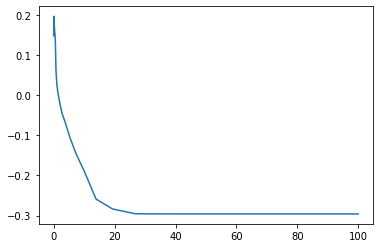

In [743]:
alpha = np.logspace(-5,2,50)
param_grid = {'alpha': alpha}
lar = Lasso()
clf_lar = GridSearchCV(lar, param_grid=param_grid, cv=tscv)
clf_lar.fit(X_train, y_train)
print(clf_lar.best_params_)
print(clf_lar.best_score_)
pd.Series(clf_lar.cv_results_['mean_test_score'],index=alpha).plot()

In [744]:
add_result(clf_lar,'lasso',True,'')

,Model,Hyperparameters,In-Sample R2,Out-of-Sample R2,Comments
0,adaboost,"{'base_estimator__max_depth': 8, 'learning_rate': 0.01, 'n_estimators': 100}",0.715079,0.594117,"wf validation, first fit"
1,Random Forest,"{'max_depth': 10, 'n_estimators': 100}",0.811008,0.698365,wf validation
2,adaboost,"{'base_estimator__max_depth': 10, 'learning_rate': 0.001, 'n_estimators': 100}",0.78032,0.657991,"wf validation, second fit"
3,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.03, 'n_estimators': 150}",0.796073,0.653159,third fit
4,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.01, 'n_estimators': 250}",0.774773,0.642767,fourth fit
5,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.005, 'n_estimators': 150}",0.755069,0.629464,fifth fit
6,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.005, 'n_estimators': 300}",0.76231,0.626387,sixth fit - checking lots of stumps
7,gradient boost,"{'learning_rate': 0.06, 'max_depth': 5, 'n_estimators': 100}",0.781381,0.636614,first fit
8,gradient boost,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}",0.771185,0.629884,second fit
9,gradient boost,"{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000}",0.824779,0.668993,"third fit, more trees"


### Random Forest

{'max_depth': 10}
0.37451614408949363


<AxesSubplot:>

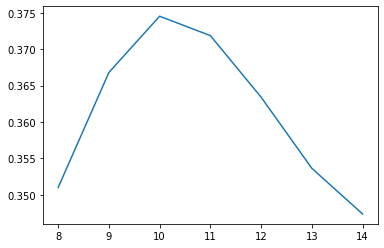

In [490]:
md = range(8,15,1)
param_grid = {'max_depth': range(8,15,1)}
rf = RandomForestRegressor(n_estimators=100)
clf_rf = GridSearchCV(rf, param_grid=param_grid, cv=tscv)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.best_params_)
print(clf_rf.best_score_)
pd.Series(clf_rf.cv_results_['mean_test_score'],index=md).plot()

In [505]:
param_grid = {'max_depth': [10], 'n_estimators':[100]}
rf = RandomForestRegressor()
clf_rf = GridSearchCV(rf, param_grid=param_grid, cv=tscv)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.best_params_)
print(clf_rf.best_score_)

{'max_depth': 10, 'n_estimators': 100}
0.37262708407110157


In [621]:
X_train.head(2)

,airline_type_dum,Region_Africa,Region_Asia,Region_Canada,Region_Europe,Region_Latin America & Caribbean,Region_USA-Midwest,Region_USA-Northeast,Region_USA-Pacific West,Region_USA-Plains,Region_USA-Southeast,Time Category_Afternoon,Time Category_Evening,Time Category_Morning,Time Category_Overnight,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,holiday
DT_sched,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:59:00,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2021-01-01 06:00:00,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [650]:
add_result(clf_rf, 'Random Forest',True,"wf validation")

,Model,Hyperparameters,In-Sample R2,Out-of-Sample R2,Comments
0,adaboost,"{'base_estimator__max_depth': 8, 'learning_rat...",0.715079,0.594117,"wf validation, first fit"
1,Random Forest,"{'max_depth': 10, 'n_estimators': 100}",0.811008,0.698365,wf validation


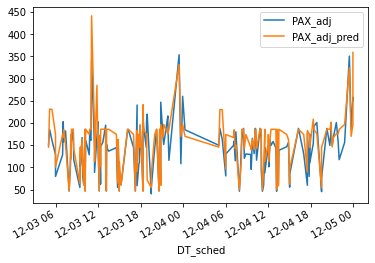

In [511]:
plot_result(clf_rf,['PAX_adj'],'2021-12-03','2021-12-05')

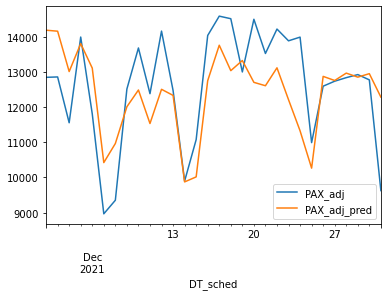

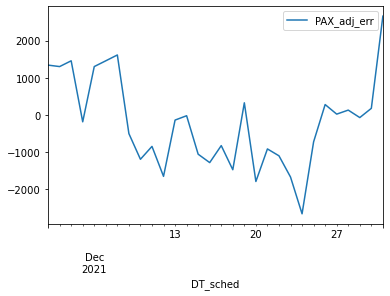

In [512]:
plot_agg_result(clf_rf,['PAX_adj'],'1D','2021-12-02','2021-12-31')

### Adaboost

In [ ]:
                'n_estimators':[50,100,150],
                'learning_rate':[.001, .005,.01,.1]

In [672]:
abr = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())

param_grid = {
                'base_estimator__max_depth':[4,9],
                'n_estimators':[300],
                'learning_rate':[.005,.01]
                }

clf_abr = GridSearchCV(abr, param_grid=param_grid,verbose=3,n_jobs=-1, cv=tscv)
clf_abr.fit(X_train,y_train['PAX_adj'])


print(clf_abr.best_params_)
print(clf_abr.best_score_)

print(r2_score(y_train['PAX_adj'], clf_abr.predict(X_train)))
print(r2_score(y_test['PAX_adj'], clf_abr.predict(X_test)))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'base_estimator__max_depth': 9, 'learning_rate': 0.005, 'n_estimators': 300}
0.39503762308613816
0.7623103898098207
0.6263870859676188


{'base_estimator__max_depth': 9, 'learning_rate': 0.005, 'n_estimators': 300}
Cross validation score: 0.39503762308613816
In sample r2: 0.7623103898098207
Out of sample r2: 0.6263870859676188


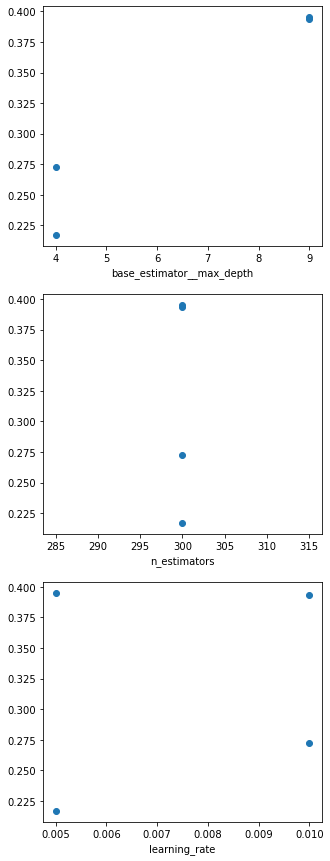

In [673]:
model_eval(clf_abr,False)

In [674]:
add_result(clf_abr,'adaboost',False,'sixth fit - checking lots of stumps')

,Model,Hyperparameters,In-Sample R2,Out-of-Sample R2,Comments
0,adaboost,"{'base_estimator__max_depth': 8, 'learning_rate': 0.01, 'n_estimators': 100}",0.715079,0.594117,"wf validation, first fit"
1,Random Forest,"{'max_depth': 10, 'n_estimators': 100}",0.811008,0.698365,wf validation
2,adaboost,"{'base_estimator__max_depth': 10, 'learning_rate': 0.001, 'n_estimators': 100}",0.78032,0.657991,"wf validation, second fit"
3,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.03, 'n_estimators': 150}",0.796073,0.653159,third fit
4,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.01, 'n_estimators': 250}",0.774773,0.642767,fourth fit
5,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.005, 'n_estimators': 150}",0.755069,0.629464,fifth fit
6,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.005, 'n_estimators': 300}",0.76231,0.626387,sixth fit - checking lots of stumps


In [677]:
# check to make sure more trees isn't going to improve r2. (not using gridsearch because it'll take too long)
abr2 = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = 9),n_estimators = 1000,learning_rate = .001)
abr2.fit(X_train, y_train['PAX_adj'])

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=9),
                  learning_rate=0.001, n_estimators=1000)

In [678]:
print(r2_score(y_train['PAX_adj'], abr2.predict(X_train)))
print(r2_score(y_test['PAX_adj'], abr2.predict(X_test)))

0.7565267137877645
0.6289296104782202


### Gradient Boosting

In [679]:
#untuned GBR
gbc = GradientBoostingRegressor(max_depth = 9)
gbc = gbc.fit(X_train,y_train['PAX_adj'])
print(gbc.score(X_train,y_train['PAX_adj']))
print(gbc.score(X_test,y_test['PAX_adj']))

0.9508203021081235
0.6709041158737158


In [697]:
gbr = GradientBoostingRegressor()

param_grid = {
                'max_depth':[5],
                'n_estimators':[1000,2000],
                'learning_rate':[.005,.007]
                }

clf_gbr = GridSearchCV(gbr, param_grid=param_grid,verbose=3,n_jobs=-1, cv=tscv,)
clf_gbr.fit(X_train,y_train['PAX_adj'])

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.005, 0.007], 'max_depth': [5],
                         'n_estimators': [1000, 2000]},
             verbose=3)

{'learning_rate': 0.005, 'max_depth': 5, 'n_estimators': 1000}
Cross validation score: 0.4324992097672579
In sample r2: 0.7637227176856078
Out of sample r2: 0.6406461615107854


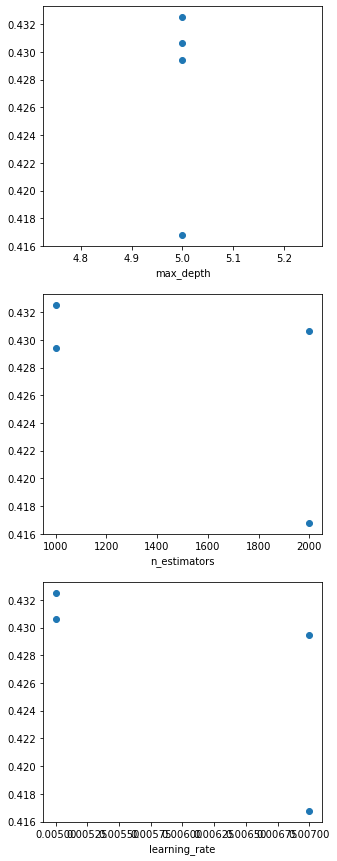

In [698]:
model_eval(clf_gbr,False)

In [699]:
add_result(clf_gbr,'gradient boost',False,'fourth fit')

,Model,Hyperparameters,In-Sample R2,Out-of-Sample R2,Comments
0,adaboost,"{'base_estimator__max_depth': 8, 'learning_rate': 0.01, 'n_estimators': 100}",0.715079,0.594117,"wf validation, first fit"
1,Random Forest,"{'max_depth': 10, 'n_estimators': 100}",0.811008,0.698365,wf validation
2,adaboost,"{'base_estimator__max_depth': 10, 'learning_rate': 0.001, 'n_estimators': 100}",0.78032,0.657991,"wf validation, second fit"
3,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.03, 'n_estimators': 150}",0.796073,0.653159,third fit
4,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.01, 'n_estimators': 250}",0.774773,0.642767,fourth fit
5,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.005, 'n_estimators': 150}",0.755069,0.629464,fifth fit
6,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.005, 'n_estimators': 300}",0.76231,0.626387,sixth fit - checking lots of stumps
7,gradient boost,"{'learning_rate': 0.06, 'max_depth': 5, 'n_estimators': 100}",0.781381,0.636614,first fit
8,gradient boost,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}",0.771185,0.629884,second fit
9,gradient boost,"{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000}",0.824779,0.668993,"third fit, more trees"


In [689]:
# check to make sure more trees isn't going to improve r2. (not using gridsearch because it'll take too long)
gbr2 = GradientBoostingRegressor(max_depth = 5,n_estimators = 1000,learning_rate = .01)
gbr2.fit(X_train, y_train['PAX_adj'])
print(r2_score(y_train['PAX_adj'], gbr2.predict(X_train)))
print(r2_score(y_test['PAX_adj'], gbr2.predict(X_test)))

0.8247794738418075
0.6692433495803831


### K Nearest Neighbor

In [700]:
knr = KNeighborsRegressor(n_neighbors = 5, weights = 'distance', n_jobs = -1)

knr.fit(X_train, y_train)

print(knr.score(X_train, y_train))
print(knr.score(X_test, y_test))

0.9787235348941601
0.5714361841949257


In [76]:
knr = KNeighborsRegressor(n_neighbors = 10, weights = 'distance', n_jobs = -1)

knr.fit(X_train, y_train)

print(knr.score(X_train, y_train))
print(knr.score(X_test, y_test))

0.8944815441512014
0.4540007771045014


Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'n_neighbors': 17}
0.2833257232422464


<AxesSubplot:>

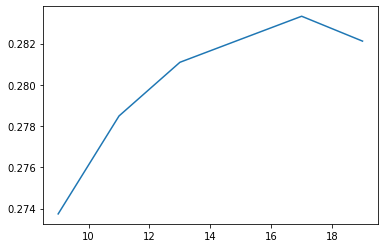

In [769]:
knr = KNeighborsRegressor(weights='distance',n_jobs=-1)

nn = [n for n in range(9,21,2)]

param_grid = {
                'n_neighbors':nn,

                }

clf_knr = GridSearchCV(knr, param_grid=param_grid,verbose=3,n_jobs=-1, cv=tscv,)
clf_knr.fit(X_train,y_train)


print(clf_knr.best_params_)

print(clf_knr.best_score_)

pd.Series(clf_knr.cv_results_['mean_test_score'],index=nn).plot()

In [709]:
add_result(clf_knr,"KNN",multioutput=True,comments='second fit, no PCA')

,Model,Hyperparameters,In-Sample R2,Out-of-Sample R2,Comments
0,adaboost,"{'base_estimator__max_depth': 8, 'learning_rate': 0.01, 'n_estimators': 100}",0.715079,0.594117,"wf validation, first fit"
1,Random Forest,"{'max_depth': 10, 'n_estimators': 100}",0.811008,0.698365,wf validation
2,adaboost,"{'base_estimator__max_depth': 10, 'learning_rate': 0.001, 'n_estimators': 100}",0.78032,0.657991,"wf validation, second fit"
3,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.03, 'n_estimators': 150}",0.796073,0.653159,third fit
4,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.01, 'n_estimators': 250}",0.774773,0.642767,fourth fit
5,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.005, 'n_estimators': 150}",0.755069,0.629464,fifth fit
6,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.005, 'n_estimators': 300}",0.76231,0.626387,sixth fit - checking lots of stumps
7,gradient boost,"{'learning_rate': 0.06, 'max_depth': 5, 'n_estimators': 100}",0.781381,0.636614,first fit
8,gradient boost,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}",0.771185,0.629884,second fit
9,gradient boost,"{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000}",0.824779,0.668993,"third fit, more trees"


Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'n_neighbors': 16}
0.23568251223286896


<AxesSubplot:>

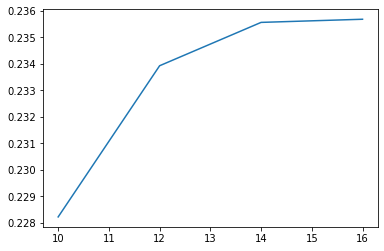

In [767]:
# use the PCs
knrp = KNeighborsRegressor(weights='distance',n_jobs=-1)
nn = [n for n in range(10,17,2)]
param_grid = {
                'n_neighbors':nn,

                }

clf_knrp = GridSearchCV(knrp, param_grid=param_grid,verbose=3,n_jobs=-1, cv=tscv,)
clf_knrp.fit(X_train_p,y_train)


print(clf_knrp.best_params_)

print(clf_knrp.best_score_)

pd.Series(clf_knrp.cv_results_['mean_test_score'],index=nn).plot()


In [768]:
r2_score(y_test, clf_knrp.predict(X_test_p))

0.34693560427257814

In [746]:
# manually add to the results table
d = {'Model':'knn','Hyperparameters':'','In-Sample R2':r2_score(y_train, clf_knrp.predict(X_train_p)),'Out-of-Sample R2':r2_score(y_test, clf_knrp.predict(X_test_p)),"Comments":'with pca'}
results = results.append(d,ignore_index=True)
results

,Model,Hyperparameters,In-Sample R2,Out-of-Sample R2,Comments
0,adaboost,"{'base_estimator__max_depth': 8, 'learning_rate': 0.01, 'n_estimators': 100}",0.715079,0.594117,"wf validation, first fit"
1,Random Forest,"{'max_depth': 10, 'n_estimators': 100}",0.811008,0.698365,wf validation
2,adaboost,"{'base_estimator__max_depth': 10, 'learning_rate': 0.001, 'n_estimators': 100}",0.78032,0.657991,"wf validation, second fit"
3,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.03, 'n_estimators': 150}",0.796073,0.653159,third fit
4,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.01, 'n_estimators': 250}",0.774773,0.642767,fourth fit
5,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.005, 'n_estimators': 150}",0.755069,0.629464,fifth fit
6,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.005, 'n_estimators': 300}",0.76231,0.626387,sixth fit - checking lots of stumps
7,gradient boost,"{'learning_rate': 0.06, 'max_depth': 5, 'n_estimators': 100}",0.781381,0.636614,first fit
8,gradient boost,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}",0.771185,0.629884,second fit
9,gradient boost,"{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000}",0.824779,0.668993,"third fit, more trees"


### MLP

In [715]:
mlp = MLPRegressor()

param_grid = {
                'hidden_layer_sizes':[(30,12),(100,50),(100,100)],
                'learning_rate':['adaptive','constant'],
                'learning_rate_init':[.001,.01],
                'tol':[.01,.1],
                'max_iter':[500]

                }

clf_mlp = GridSearchCV(mlp, param_grid=param_grid,verbose=3,n_jobs=-1, cv=tscv,)
clf_mlp.fit(X_train,y_train['PAX_adj'])


print(clf_mlp.best_params_)
print(clf_mlp.best_score_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'hidden_layer_sizes': (30, 12), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 500, 'tol': 0.1}
0.2895112902110679


In [724]:
clf_mlp.cv_results_

{'mean_fit_time': array([ 49.77556057,  51.40910921,  23.92086549,  22.05577316,
         60.4371314 ,  59.99085999,  28.65888004,  32.71296988,
        118.81105318, 120.95384121,  50.74520793,  68.95934672,
        129.86823039, 123.94073267,  58.4627665 ,  54.95181751,
        176.63224649, 167.57233491,  75.38747482,  96.65374851,
        177.83922381, 137.21187344,  70.84164491,  69.86629472]),
 'std_fit_time': array([25.25571655, 29.09396187, 13.02289326,  8.29950005, 29.16707999,
        26.35183624, 10.99780616, 10.17826917, 53.79348557, 53.3947181 ,
        28.99511221, 45.76396109, 62.98210603, 60.49000311, 31.37756026,
        45.92254002, 83.04817766, 79.75020172, 36.53916689, 76.94256452,
        97.62166709, 61.64716563, 52.94976881, 37.1852414 ]),
 'mean_score_time': array([0.02852216, 0.01396441, 0.01675935, 0.01436167, 0.01439834,
        0.02138038, 0.01343269, 0.02455311, 0.04612556, 0.03292594,
        0.03015833, 0.04031014, 0.05232005, 0.03626394, 0.04176555,
    

In [717]:
add_result(clf_mlp,'MLP',False,'trying a wide range of parameters')

,Model,Hyperparameters,In-Sample R2,Out-of-Sample R2,Comments
0,adaboost,"{'base_estimator__max_depth': 8, 'learning_rate': 0.01, 'n_estimators': 100}",0.715079,0.594117,"wf validation, first fit"
1,Random Forest,"{'max_depth': 10, 'n_estimators': 100}",0.811008,0.698365,wf validation
2,adaboost,"{'base_estimator__max_depth': 10, 'learning_rate': 0.001, 'n_estimators': 100}",0.78032,0.657991,"wf validation, second fit"
3,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.03, 'n_estimators': 150}",0.796073,0.653159,third fit
4,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.01, 'n_estimators': 250}",0.774773,0.642767,fourth fit
5,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.005, 'n_estimators': 150}",0.755069,0.629464,fifth fit
6,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.005, 'n_estimators': 300}",0.76231,0.626387,sixth fit - checking lots of stumps
7,gradient boost,"{'learning_rate': 0.06, 'max_depth': 5, 'n_estimators': 100}",0.781381,0.636614,first fit
8,gradient boost,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}",0.771185,0.629884,second fit
9,gradient boost,"{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000}",0.824779,0.668993,"third fit, more trees"


## Save the best models

In [749]:
results = results.sort_values(by='Out-of-Sample R2',ascending=False).reset_index(drop=True)
results

,Model,Hyperparameters,In-Sample R2,Out-of-Sample R2,Comments
0,Random Forest,"{'max_depth': 10, 'n_estimators': 100}",0.811008,0.698365,wf validation
1,gradient boost,"{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000}",0.824779,0.668993,"third fit, more trees"
2,adaboost,"{'base_estimator__max_depth': 10, 'learning_rate': 0.001, 'n_estimators': 100}",0.78032,0.657991,"wf validation, second fit"
3,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.03, 'n_estimators': 150}",0.796073,0.653159,third fit
4,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.01, 'n_estimators': 250}",0.774773,0.642767,fourth fit
5,gradient boost,"{'learning_rate': 0.005, 'max_depth': 5, 'n_estimators': 1000}",0.763723,0.640646,fourth fit
6,gradient boost,"{'learning_rate': 0.06, 'max_depth': 5, 'n_estimators': 100}",0.781381,0.636614,first fit
7,gradient boost,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}",0.771185,0.629884,second fit
8,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.005, 'n_estimators': 150}",0.755069,0.629464,fifth fit
9,adaboost,"{'base_estimator__max_depth': 9, 'learning_rate': 0.005, 'n_estimators': 300}",0.76231,0.626387,sixth fit - checking lots of stumps


In [750]:
# save modeling results to csv
results.to_csv('pax_modeling_results.csv')

In [ ]:
#save best tuned model of each type (ols, ridge, lasso, knn, random forest, adaboost, gradient boost, mlp)

In [771]:
#best ols, ridge, lasso, knn
joblib.dump(lr, 'ols.pkl')
joblib.dump(clf_rr.best_estimator_, 'ridge.pkl')
joblib.dump(clf_lar.best_estimator_, 'lasso.pkl')
joblib.dump(clf_knr.best_estimator_, 'knn.pkl')

['knn.pkl']

In [763]:
#best random forest model
joblib.dump(clf_rf.best_estimator_, 'rf.pkl')

['rf.pkl']

In [758]:
#can't do multioutput regression for GBR so exporting 3 models
#gradient boosting model for all pax
gbr_all_best = GradientBoostingRegressor(learning_rate = 0.01, max_depth = 5, n_estimators = 1000)
gbr_all_best.fit(X_train, y_train['PAX_adj'])
print(r2_score(y_train['PAX_adj'],gbr_all_best.predict(X_train)))
print(r2_score(y_test['PAX_adj'],gbr_all_best.predict(X_test)))

0.8247794738418075
0.6680267783695456


In [756]:
#gradient boosting model for business pax
gbr_bus_best = GradientBoostingRegressor(learning_rate = 0.01, max_depth = 5, n_estimators = 1000)
gbr_bus_best.fit(X_train, y_train['PAX_bus'])
print(r2_score(y_train['PAX_bus'],gbr_bus_best.predict(X_train)))
print(r2_score(y_test['PAX_bus'],gbr_bus_best.predict(X_test)))

0.8993957648804622
0.7786561018956881


In [757]:
#gradient boosting model for leisure pax
gbr_lei_best = GradientBoostingRegressor(learning_rate = 0.01, max_depth = 5, n_estimators = 1000)
gbr_lei_best.fit(X_train, y_train['PAX_lei'])
print(r2_score(y_train['PAX_lei'],gbr_lei_best.predict(X_train)))
print(r2_score(y_test['PAX_lei'],gbr_lei_best.predict(X_test)))

0.8362199617941564
0.67999598079194


In [759]:
joblib.dump(gbr_all_best, 'gbr_all_best.pkl')
joblib.dump(gbr_bus_best, 'gbr_bus_best.pkl')
joblib.dump(gbr_lei_best, 'gbr_lei_best.pkl')

['gbr_lei_best.pkl']

In [731]:
#mlp
joblib.dump(clf_mlp.best_estimator_, 'mlp.pkl')

['mlp.pkl']

## Visualize best models

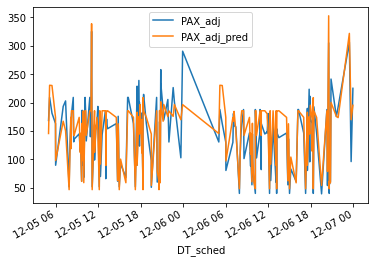

In [778]:
plot_result(clf_rf,['PAX_adj'],'2021-12-05','2021-12-07')

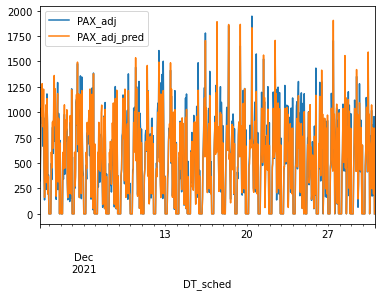

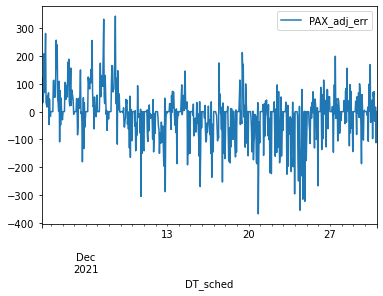

In [783]:
# within 1 hour periods, the best model is usually not off by more than 200 passengers in either direction
plot_agg_result(clf_rf,['PAX_adj'],'1H','2021-12-02','2021-12-31')

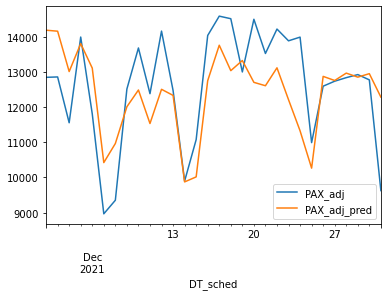

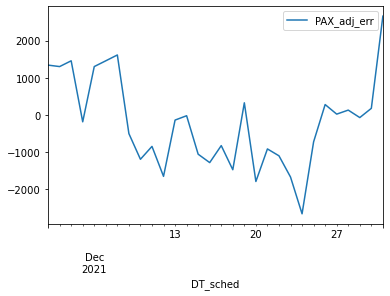

In [784]:
# in a given day, rarely off by more than 2000 passengers
plot_agg_result(clf_rf,['PAX_adj'],'1D','2021-12-02','2021-12-31')